In [70]:
#import sqlite3
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [65]:

def hill(series,k,s):

    return 1/(1+(series/k)**s)

def adstock(decayRate,series):

    v=[(decayRate)**k for k in range(len(series))]
    transform = np.convolve(a=series,
        v=v
        )[:len(series)]
        
    return transform

def adjust_channel(series,decayRate,hillMidpoint,hillShape):

    transform = hill(series,hillMidpoint,hillShape)
    transform = adstock(decayRate,transform)

    return transform

In [66]:
"""conn = sqlite3.connect("../../data/marketing_sqlite.db")
dat = pd.read_sql("select * from RAW_MARKETING_SET_3",con=conn)

nameMapping = {
    'TARGET':'Sales ($)'
    }

nameMappingFlip = {nameMapping[i]:i for i in nameMapping.keys()}
dat.rename(mapper=nameMappingFlip,axis=1,inplace=True)"""

'conn = sqlite3.connect("../../data/marketing_sqlite.db")\ndat = pd.read_sql("select * from RAW_MARKETING_SET_3",con=conn)\n\nnameMapping = {\n    \'TARGET\':\'Sales ($)\'\n    }\n\nnameMappingFlip = {nameMapping[i]:i for i in nameMapping.keys()}\ndat.rename(mapper=nameMappingFlip,axis=1,inplace=True)'

In [93]:
#FAKE DATA
dat = pd.DataFrame({'DATE':pd.date_range('2021-01-01','2022-11-01')})

dat['CH1'] = np.random.normal(700,200,len(dat))
dat['CH2'] = np.random.normal(1400,200,len(dat))
dat['CH3'] = np.random.normal(1000,200,len(dat))
dat['CH4'] = np.random.normal(50,10,len(dat))
dat['CH5'] = np.random.normal(110,15,len(dat))
dat['CH6'] = np.random.normal(600,200,len(dat))

dat[[i for i in dat if 'CH' in i]] = np.round(np.where(dat[[i for i in dat if 'CH' in i]]<0,
    0,
    dat[[i for i in dat if 'CH' in i]]),2)

for i in range(0,7):
    dat[f'S_D_{i}'] = np.where(dat['DATE'].dt.weekday==i,1,0)

for i in range(1,13):
    dat[f'S_M_{i}'] = np.where(dat['DATE'].dt.month==i,1,0)

mediaCols = [i for i in dat.columns if 'CH' in i]
seasonalCols = [i for i in dat.columns if 'S_' in i]

mediaDat = dat[['DATE']+mediaCols].copy()

mediaDatTransformed = mediaDat.copy()

transformParams = {
    'CH1':{
        'decayRate':.5,
        'hillMidPoint':np.quantile(mediaDat['CH1'],.9),
        'hillShape':-.5,
    },
    'CH2':{
        'decayRate':.5,
        'hillMidPoint':np.quantile(mediaDat['CH2'],.9),
        'hillShape':-.5,
    },
    'CH3':{
        'decayRate':.5,
        'hillMidPoint':np.quantile(mediaDat['CH3'],.9),
        'hillShape':-.5,
    },
    'CH4':{
        'decayRate':.5,
        'hillMidPoint':np.quantile(mediaDat['CH4'],.9),
        'hillShape':-.5,
    },
    'CH5':{
        'decayRate':.5,
        'hillMidPoint':np.quantile(mediaDat['CH5'],.9),
        'hillShape':-.5,
    },
    'CH6':{
        'decayRate':.5,
        'hillMidPoint':np.quantile(mediaDat['CH6'],.9),
        'hillShape':-.5,
    },                        
}

for col in mediaCols:
    mediaDatTransformed[col] = adjust_channel(mediaDatTransformed[col],
        transformParams[col]['decayRate'],
        transformParams[col]['hillMidPoint'],
        transformParams[col]['hillShape']
    )

seasonalDat = dat[['DATE']+seasonalCols].copy()

modelingDat = mediaDatTransformed.merge(seasonalDat,on=['DATE'],how='left')


allCols = mediaCols+seasonalCols

coefs = np.concatenate([np.random.normal(100,20,len(mediaCols)),
    np.random.normal(15,4,len(seasonalCols))])
coefs = np.where(coefs<0,0,coefs)

modelingDat['TARGET'] = modelingDat[allCols]@coefs+np.random.normal(0,15,len(modelingDat))


In [94]:
modelingDat

,DATE,CH1,CH2,CH3,CH4,CH5,CH6,S_D_0,S_D_1,S_D_2,...,S_M_4,S_M_5,S_M_6,S_M_7,S_M_8,S_M_9,S_M_10,S_M_11,S_M_12,TARGET
0,2021-01-01,0.480421,0.475344,0.468346,0.481236,0.496676,0.457280,0,0,0,...,0,0,0,0,0,0,0,0,0,315.612128
1,2021-01-02,0.673137,0.719199,0.750221,0.707208,0.717112,0.597262,0,0,0,...,0,0,0,0,0,0,0,0,0,471.801669
2,2021-01-03,0.771504,0.829378,0.885426,0.760860,0.820164,0.701407,0,0,0,...,0,0,0,0,0,0,0,0,0,545.650595
3,2021-01-04,0.797057,0.900453,0.889173,0.848132,0.902035,0.800670,1,0,0,...,0,0,0,0,0,0,0,0,0,570.633269
4,2021-01-05,0.842374,0.939291,0.935369,0.884916,0.922465,0.885708,0,1,0,...,0,0,0,0,0,0,0,0,0,592.215046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,2022-10-28,0.908278,0.912196,0.974997,0.927082,0.956792,0.876526,0,0,0,...,0,0,0,0,0,0,1,0,0,606.237387
666,2022-10-29,0.958466,0.940014,0.958203,0.965864,0.948129,0.898456,0,0,0,...,0,0,0,0,0,0,1,0,0,610.472034
667,2022-10-30,0.931521,0.973683,0.991318,0.940619,0.930143,0.913626,0,0,0,...,0,0,0,0,0,0,1,0,0,636.793771
668,2022-10-31,0.913447,0.939432,1.000673,0.950942,0.941217,0.973902,1,0,0,...,0,0,0,0,0,0,1,0,0,604.692366


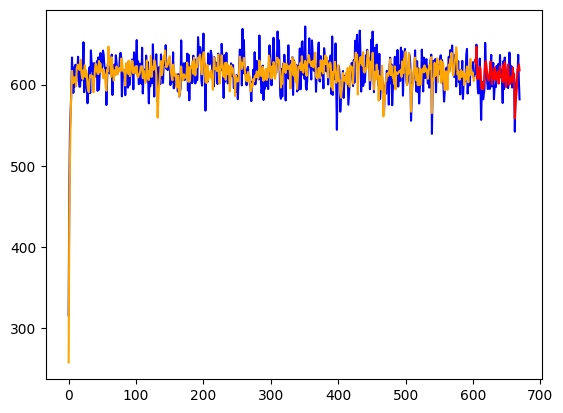

In [95]:
feats = [i for i in allCols if '_4' not in i]

X = modelingDat[allCols].copy()
y = modelingDat['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.1, random_state=42,shuffle=False
)

pipe=Pipeline(
    steps=[
        ('scaler',MinMaxScaler()),
        ('lr',Ridge(positive=True,fit_intercept=False,alpha=.1))
    ]
).fit(X_train,y_train)

y_fit = pd.Series(pipe.predict(X_train),index=y_train.index)
y_pred = pd.Series(pipe.predict(X_test),index=y_test.index)

plt.plot(y_train,color='blue')
plt.plot(y_fit,color='orange')
plt.plot(y_test,color='blue')
plt.plot(y_pred,color='red')

In [96]:
pipe['lr'].coef_

array([ 66.97890017, 110.20907067,  48.95709313,  51.75558143,
        71.37395913,  77.19666038, 164.25870406, 158.0859701 ,
       157.05503186, 159.79256677, 154.8301738 , 162.85197814,
       159.43503235,  92.80418667,  88.51408446, 101.05059711,
        90.03215038,  95.78500906,  91.28612999,  97.47240723,
        92.51888144,  90.6416449 ,  86.2822842 ,  96.04945735,
        93.87262429])

In [97]:
coefs

array([118.40449566, 108.95200702,  82.54261478, 106.50422815,
       112.17190159,  95.67564699,  21.55266268,  16.11064833,
        16.8785005 ,  15.55822782,  12.5338831 ,  19.62984206,
        16.16980187,  13.65563272,  14.3661943 ,  24.85185176,
        10.82322843,  20.45672687,  13.62775044,  16.07095682,
        11.97904155,  12.36660638,   7.38711138,  15.87613435,
        14.26023568])

In [108]:
## BELOW: LOAD FAKE DATA AND MODEL FROM SOURCE

DatIn = dat.merge(modelingDat[['DATE','TARGET']],on=['DATE'],how='left')

mediaCols = [i for i in DatIn if ('CH' in i)&('_shift1' not in i)]
seasonalCols = [i for i in DatIn if ('S_' in i)]
allCols = mediaCols+seasonalCols

for c in mediaCols:

    DatIn[f'{c}_shift1'] = DatIn[c].shift(1)

shiftCols = [i for i in DatIn if ('_shift1' in i)]



In [122]:

## MEASURE ADSTOCK
X = DatIn.dropna()[allCols+shiftCols].copy()
y = DatIn.dropna()['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.1, random_state=42,shuffle=False
)

pipe=Pipeline(
    steps=[
        ('scaler',MinMaxScaler()),
        ('lr',Ridge(positive=True,fit_intercept=False,alpha=1e-1))
    ]
).fit(X_train,y_train)


coefDF = pd.DataFrame({'feat':allCols+shiftCols,
    'coef':pipe['lr'].coef_})

coefDF['source']=coefDF['feat'].str.split("_",expand=True)[0]

coefDF = coefDF[coefDF['feat'].isin(mediaCols)].merge(
    coefDF[coefDF['feat'].isin(shiftCols)][['source','coef']],how='left',on='source')

coefDF.columns=['feat','coef','source','shift_coef']

coefDF['adstock'] = coefDF['shift_coef']/coefDF['coef']

coefDF['adstock'] = np.where(coefDF['adstock']>.99,.99,
np.where(coefDF['adstock']<0,0,coefDF['adstock']))

coefDF



,feat,coef,source,shift_coef,adstock
0,CH1,35.031038,CH1,22.479783,0.641710
1,CH2,26.061890,CH2,24.423449,0.937133
2,CH3,19.883356,CH3,11.763968,0.591649
3,CH4,17.914206,CH4,14.154198,0.790110
4,CH5,22.725784,CH5,7.673044,0.337636
5,CH6,56.470812,CH6,25.494436,0.451462


In [136]:

DatIn[mediaCols+['TARGET']].corr()


,CH1,CH2,CH3,CH4,CH5,CH6,TARGET
CH1,1.000000,0.008702,-0.054874,-0.015872,-0.030204,-0.001656,0.188350
CH2,0.008702,1.000000,-0.005678,-0.035763,-0.019633,-0.093073,0.079224
CH3,-0.054874,-0.005678,1.000000,0.025709,0.070005,0.018996,0.094578
CH4,-0.015872,-0.035763,0.025709,1.000000,0.052463,0.033003,0.066751
CH5,-0.030204,-0.019633,0.070005,0.052463,1.000000,-0.017158,0.049138
CH6,-0.001656,-0.093073,0.018996,0.033003,-0.017158,1.000000,0.297837
TARGET,0.188350,0.079224,0.094578,0.066751,0.049138,0.297837,1.000000


In [268]:
from scipy.optimize import minimize

col = DatIn['CH1']
y = DatIn['TARGET']

def model(x,params):

    return params[0]/(1+(x/params[1])**params[2])+params[3]

def cost(params):

    Yexp = model(col,params)

    return sum((y-Yexp)**2)

def jacobian(params):

    return x

cost_optimized = minimize(
    fun=cost,
    x0=np.zeros(4),
    #method='Nelder-Mead',
    method='Powell',
    options={'maxiter':10000}
)

params = cost_optimized['x']

params

array([ 1.24128701e+03,  4.35995364e+00, -4.39814328e-02, -7.48754063e+01])

In [256]:

col = DatIn['CH1']
y = DatIn['TARGET']

def model(x,c,k,s,d):

    return c/(1+(x/k)**s) + d

def err(y,x,c,k,s,d):

    return y-model(x,c,k,s,d)

def grad_c(y,x,c,k,s,d):

    return sum(2*err(y,x,c,k,s,d)*((1+((k**-1)*x)**s)**-1))
    
def grad_k(y,x,c,k,s,d):

    return sum(2*err(y,x,c,k,s,d)*(-c)*(1+(x*(k**-1))**s)**(-2)*s*(x*k**-1)**(s-1)*(-x*k**-2))
    
def grad_s(y,x,c,k,s,d):

    return sum(2*err(y,x,c,k,s,d)*(-c)*(1+(x*(k**-1))**s)**(-2)*np.log(x*k**-1)*(x*k**-1)**(s))

def grad_d(y,x,c,k,s,d):

    return sum(2*err(y,x,c,k,s,d))
    
k = np.quantile(col,.9)
s=-1
c = np.mean(col)/np.mean(y)
d = np.mean(y)
print(c,k,s,d)

print(model(col,c,k,s,d))


1.1394724943266858 950.947 -1 614.0804447700793
0      614.605629
1      614.500026
2      614.504371
3      614.454217
4      614.523802
          ...    
665    614.613827
666    614.660041
667    614.542430
668    614.532253
669    614.422340
Name: CH1, Length: 670, dtype: float64


In [257]:
"""lr = 1e-6
for x_row,y_row in zip(col,y):
    
    c,k,s = (c + lr*grad_c(y_row,x_row,c,k,s),
    k + lr*grad_k(y_row,x_row,c,k,s),
    s + lr*grad_s(y_row,x_row,c,k,s)
    )
    """

'lr = 1e-6\nfor x_row,y_row in zip(col,y):\n    \n    c,k,s = (c + lr*grad_c(y_row,x_row,c,k,s),\n    k + lr*grad_k(y_row,x_row,c,k,s),\n    s + lr*grad_s(y_row,x_row,c,k,s)\n    )\n    '

In [262]:
lr = 5e-5
lrc,lrk,lrs,lrd = lr,lr,lr,lr
#lgc,lgk,lgs,lgrd = 0,0,0,0

for i in range(500000):

    gc = grad_c(y,col,c,k,s,d)
    gk = grad_k(y,col,c,k,s,d)
    gs = grad_s(y,col,c,k,s,d)
    gd = grad_d(y,col,c,k,s,d)
    """
    if i!=0:
        lrc = abs(lgc-gc)*lr
        lrk = abs(lgk-gk)*lr
        lrs = abs(lgs-gs)*lr
        lrd = abs(lgd-gd)*lr
    """
    c,k,s,d = (c + lrc*gc,
    k + lrk*gk,
    s + lrs*gs,
    d + lrd*gd
    )

    lgc = gc
    lgk = gk
    lgs = gs
    lgd = gd

    #print(c,k,s)

    print(i,sum(err(y,col,c,k,s,d)**2),np.std(model(col,c,k,s,d)),np.std(y),c,k,s,d)

0 351347.3258242172 3.95088648828132 23.32109332770857 33.88028297940937 947.3541311704514 -1.7532761211004484 601.8418546204517
1 351347.06296577334 3.950970720042385 23.32109332770857 33.88351979023019 947.3540094443196 -1.7530818532777945 601.8402375680251
2 351346.8002222533 3.9510555600485358 23.32109332770857 33.8867564799479 947.3538877265555 -1.7528880517290566 601.8386219949012
3 351346.53759343503 3.9511409848433527 23.32109332770857 33.88999303110364 947.3537660176653 -1.7526947020286503 601.8370078658031
4 351346.2750791077 3.951226973588234 23.32109332770857 33.89322942668177 947.3536443181439 -1.7525017914589662 601.8353951461726
5 351346.0126790641 3.951313506890402 23.32109332770857 33.89646565015757 947.3535226284724 -1.7523093082299765 601.8337838023584
6 351345.75039310864 3.951400566295933 23.32109332770857 33.89970168550816 947.3534009491177 -1.7521172411422772 601.8321738016781
7 351345.4882210531 3.9514881340650274 23.32109332770857 33.90293751720801 947.35327928

KeyboardInterrupt: 

0      616.655831
1      611.395789
2      611.606382
3      609.219177
4      612.555727
          ...    
665    617.072568
666    619.428380
667    613.476329
668    612.972203
669    607.759003
Name: CH1, Length: 670, dtype: float64
43.77279008759513 948.7004571803832 -1.327984581495221 597.0046869858852


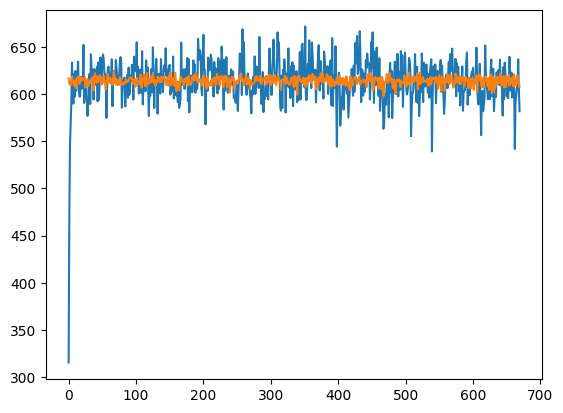

In [ ]:
print(model(col,c,k,s,d))
print(c,k,s,d)

plt.plot(y)
plt.plot(model(col,c,k,s,d))

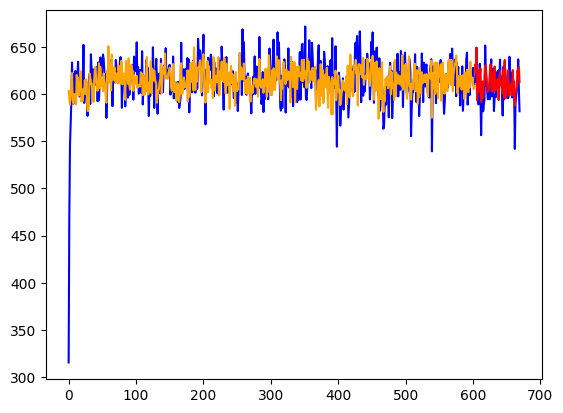

In [98]:


X = DatIn[allCols].copy()
y = DatIn['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.1, random_state=42,shuffle=False
)

pipe=Pipeline(
    steps=[
        ('scaler',MinMaxScaler()),
        ('lr',Ridge(positive=True,fit_intercept=False,alpha=1e-1))
    ]
).fit(X_train,y_train)

y_fit = pd.Series(pipe.predict(X_train),index=y_train.index)
y_pred = pd.Series(pipe.predict(X_test),index=y_test.index)

plt.plot(y_train,color='blue')
plt.plot(y_fit,color='orange')
plt.plot(y_test,color='blue')
plt.plot(y_pred,color='red')

pipe=Pipeline(
    steps=[
        ('scaler',MinMaxScaler()),
        ('lr',Ridge(positive=True,fit_intercept=False,alpha=1e-1))
    ]
).fit(X,y)



In [99]:
pipe['lr'].coef_

array([ 35.55153083,  27.19643882,  19.2643145 ,  15.60627884,
        15.65802453,  55.53783818, 339.90072555, 335.02392054,
       335.62382583, 336.84948397, 327.31769861, 337.87917497,
       336.31748764, 186.17703303, 192.02979525, 205.32657671,
       193.35091995, 198.03450558, 193.90863237, 201.71753733,
       196.32297647, 191.43450843, 191.71844173, 199.39008901,
       199.50130126])

In [100]:
EffectDat = pd.DataFrame(
    pipe['scaler'].transform(DatIn[allCols])*pipe['lr'].coef_,
    columns = allCols)

<AxesSubplot: >

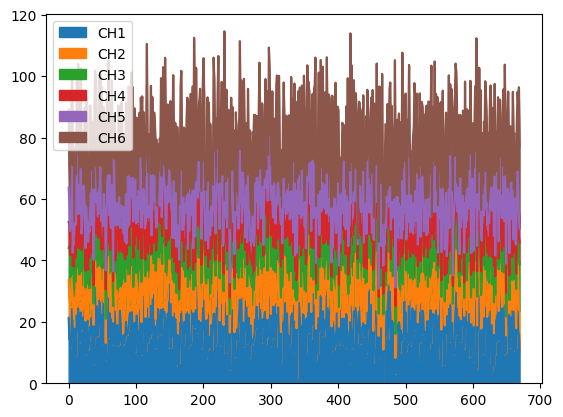

In [102]:
EffectDat[mediaCols].plot.area()

<AxesSubplot: >

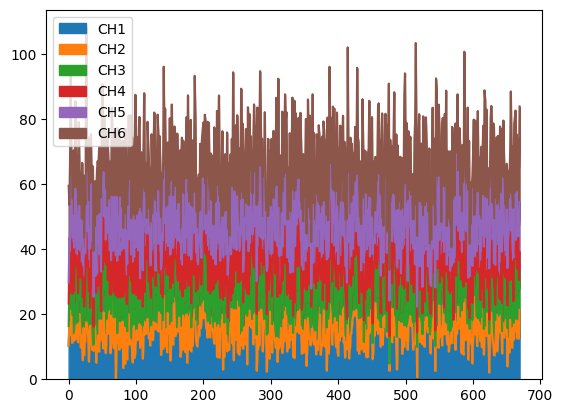

In [92]:
EffectDat[mediaCols].plot.area()